# Reading and understanding the data

In [124]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from chemception.chemception_transfer import Chemception
from chemception.Featurizer import ChemCeptionizer
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau

train_df = pd.read_csv('data/train_aid686978_0.7.csv')
train_df.head()

,smiles,label
0,CCc1ccc(CN2CCN(Cc3ccc(SC)cc3)CC2)cc1,1.0
1,NC(Cc1ccc(C(F)(F)F)cc1)c1csc(NC(=O)NCCc2ccccc2)n1,1.0
2,CC(=O)NCCNC(=O)c1cccc(NS(=O)(=O)c2ccc3c(c2)OCC...,0.0
3,COC(=O)c1ccccc1S(=O)(=O)N1CCC(C(=O)N(C)CCOc2cc...,0.0
4,O=C(CNC(=O)c1ccc(Cl)cc1Cl)OCN1C(=O)c2ccccc2C1=O,0.0


`SMILES` are a way to represent molecules as strings. This represenation is a standard in the Chemistry community and is usually parsed to other representaions of the molecule. For example, the `RDKit` library can parse SMILES to a `Mol` object.

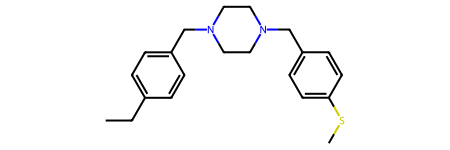

In [16]:
Chem.MolFromSmiles(train_df['smiles'].iloc[0])

We will use this represntation as a first step for our featurization. We will use the `RDKit` library to parse the SMILES to a `Mol` object for all the data.

In [125]:
train_df["mol"] = train_df["smiles"].apply(Chem.MolFromSmiles)

# Featurizing

The featurization process is the backbone of the paper we adopted, the paper chose certain feature that well describe the molecule and used them as features for the model. Which is inline with what we have learned in picking features for our data.

Since we are using a `CNN` Model, our featurization method will be dependent on an image represtnation of the molecule. However, we do some feature engineering that extract important aspects of the molecule (`bonds_order`, `atom_types`, `hybridization`, and `gasteiger_charges`) and use them as features for our model.


![Alt text](images/Featurizer.png)

In [126]:
# This is the featurizer we used, can be found in Featurizer.py
featureizer = ChemCeptionizer(embed=20, fuse=True)

# Featurize the molecules
train_df["molimage"] = train_df["mol"].apply(featureizer.featurize)

### Visualize the results of the featurization process

Text(0.5, 1.0, 'Hybridization Channel')

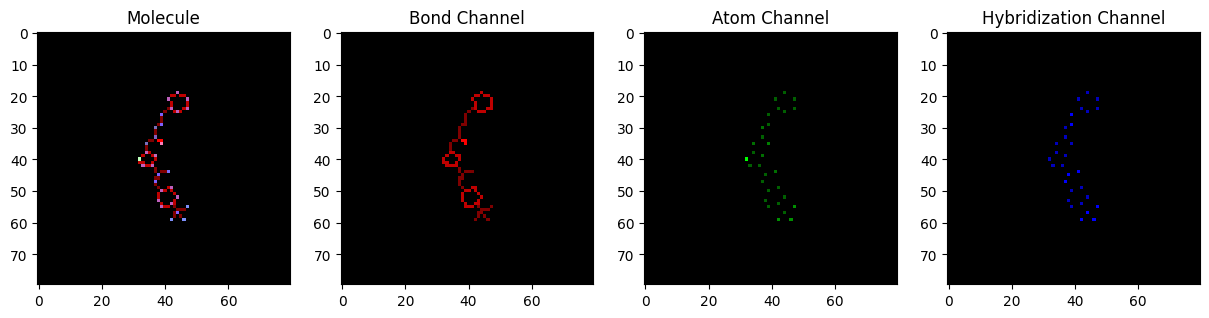

In [127]:
def show_channel(v, channel_ind):
    """
    Returns a copy of the molecule image with only the specified channel
    """
    v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
    if channel_ind >= 3:
        v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    else:
        v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    return v_copy


sample = train_df["molimage"].iloc[1]
ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(sample)
ax[1].imshow(ch1)
ax[2].imshow(ch2)
ax[3].imshow(ch3)
ax[0].set_title("Molecule")
ax[1].set_title("Bond Channel")
ax[2].set_title("Atom Channel")
ax[3].set_title("Hybridization Channel")


The featurization is working correctly, we proceed to model building

# Preparing generator and data for fitting

![Alt text](images/Featurizer.png) <br>
##### It can be observed from the above image the orientation difference between the original image and our featurization result. Since our featurization method in recontructing the molecule image using our selected features, we can assure the `0` intra-class variation, hence, we do not need augmentation.

In [128]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(data_format='channels_last')

train_df.dropna(subset=["molimage"], inplace=True)
X_train = train_df["molimage"].to_numpy()
X_train = np.stack(X_train, axis=0)
y_train = train_df["label"].to_numpy()


indeces_where_nan = np.any(np.isnan(X_train), axis=(1, 2, 3))
X_train = X_train[~indeces_where_nan]
y_train = y_train[~indeces_where_nan]

batch_size=256
g = generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

#### Define a pipeline for the data

In [27]:
def data_featurizer(df):
    
    """
    takes a dataframe with smiles and labels and returns a numpy array of the featurized images and a numpy array of the labels
    """
    df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
    df["molimage"] = df["mol"].apply(featureizer.featurize)
    df = df.dropna(subset=["molimage"])
    
    X = df["molimage"].to_numpy()
    X = np.stack(X, axis=0)
    y = df["label"].to_numpy()
    
    # remove any rows with nan values
    indeces_where_nan = np.any(np.isnan(X), axis=(1, 2, 3))
    X = X[~indeces_where_nan]
    y = y[~indeces_where_nan]
    
    return X, y

# Building the model

Due to resource limitations, we will use CNN model with an `InceptionV3` model (`Chemception` is highly influenced by the `InceptionV3` model) as a base model. We will use the `bonds_order`, `atom_types`, `hybridization`, and `gasteiger_charges` as features for the model.

### Challenges

As stated above we used 4 features for featurization, however, the `InceptionV3` model was trained on `RGB` images, so we had to find a way to convert our features to `RGB` images. We had two options:
1. Discard the last feature (`gasteiger_charges`) and use the other 3 features as `RGB` images. But we will lost a valuable feature.
2. Use weighted fusion to combine the 4 features into a single `RGB` image. This way, we maintained a valuable feature that could create a great variation in the images.

We chose the second option, with the following results:
* Before:
<br><br>
<div>
<img src="images/Featurizer.png" width="800"/>
</div><br><br><br>
* After:
<br><br>
<div>
<img src="images/after_fusion.png" width="800"/>
</div>

In [114]:
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

model = Chemception(neurons=128, dropout=0.1, dense_layers=1)
model = model.build()
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 39, 39, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 39, 39, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 39, 39, 32)   0           ['batch_normalization_282[

# Fit the model

### hyperparameters optimization
We used hyperband and bayesian optimization to find the best hyperparameters for our model. We used the `hypbandster` library for the and results can be found in the ./hyperbandster/visualizer.ipynb notebook.
<br>
<br>
<div>
<img src="images/hpbandster.png" width="500"/>
</div><br>
<br>
`Best hyperparameters: {'dense_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'neurons': 128}`

#### Load validation data

In [6]:
val_df = pd.read_csv('data/val_aid686978_0.7.csv')
X_val, y_val = data_featurizer(val_df)

#### With early stopping

In [10]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)
model.fit(g, epochs=100, steps_per_epoch=len(X_train)/batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
# model.save('chemception_transfer.h5')

Epoch 1/100
238/238 [==============================] - 30s 82ms/step - loss: 0.6720 - accuracy: 0.6001 - val_loss: 0.6499 - val_accuracy: 0.6258
Epoch 2/100
238/238 [==============================] - 16s 69ms/step - loss: 0.6487 - accuracy: 0.6262 - val_loss: 0.6467 - val_accuracy: 0.6290
Epoch 3/100
238/238 [==============================] - 17s 69ms/step - loss: 0.6411 - accuracy: 0.6327 - val_loss: 0.6452 - val_accuracy: 0.6275
Epoch 4/100
238/238 [==============================] - 17s 69ms/step - loss: 0.6376 - accuracy: 0.6384 - val_loss: 0.6447 - val_accuracy: 0.6290
Epoch 5/100
238/238 [==============================] - 16s 69ms/step - loss: 0.6355 - accuracy: 0.6394 - val_loss: 0.6449 - val_accuracy: 0.6283
Epoch 6/100
238/238 [==============================] - 17s 69ms/step - loss: 0.6323 - accuracy: 0.6437 - val_loss: 0.6460 - val_accuracy: 0.6286
Epoch 7/100
238/238 [==============================] - 16s 69ms/step - loss: 0.6306 - accuracy: 0.6444 - val_loss: 0.6427 - val_ac

#### Without early stopping

In [17]:
model.fit(g, epochs=10, steps_per_epoch=len(X_train)/batch_size, validation_data=(X_val, y_val))
# model.save('chemception_transfer_train.h5')

Epoch 1/10
164/238 [===================>..........] - ETA: 3s - loss: 0.3570 - accuracy: 0.8466

KeyboardInterrupt: 

# load the model

In [121]:
from keras.models import load_model
model = load_model('chemception_transfer.h5')

# Test the model on test data

In [28]:
test_df = pd.read_csv('data/test_aid686978_0.7.csv')
X_test, y_test = data_featurizer(test_df)

### ROC curve

We could not find other papers that have done studies on the same dataset, but a similar test was done in the 'HIV' dataset. ROC scores are the following `(~0.74)`
adjust the size of the image
<br><br>
<div>
<img src="images/hiv_roc.png" width="500"/>
</div>

410/410 [==============================] - 14s 30ms/step


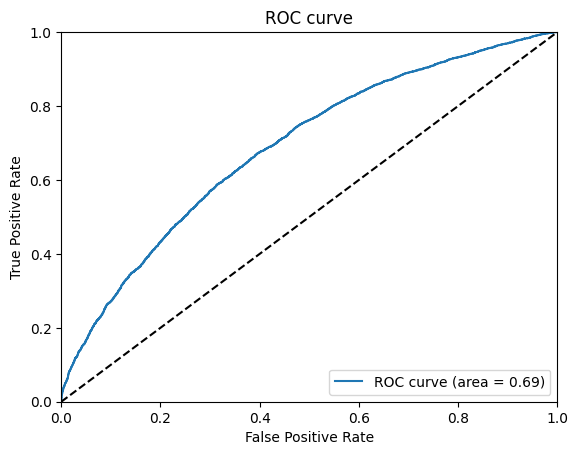

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### We got a ROC of 0.69 which is great given the available resources.

# Kernel Visualization

Kernel visualization is a technique that helps domain experts under the model's decision making process. It is a great tool for debugging and understanding the model.

In [129]:

def plot_kernels(kernels, layer_name):
    fig, axes = plt.subplots(2,3, figsize=(12,8))
    for i,ax in enumerate(axes.flatten()):
        # add color to values legend
        ax.imshow(kernels[:,:,i], cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"layer: {layer_name} Kernel %s"%i)


1/1 [==============================] - 0s 73ms/step


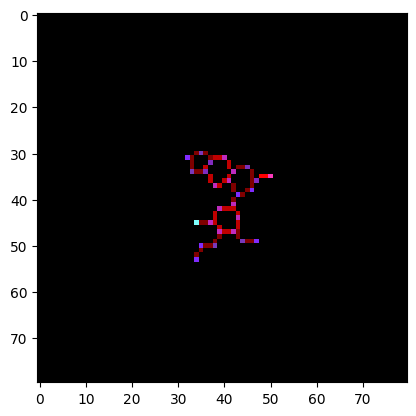

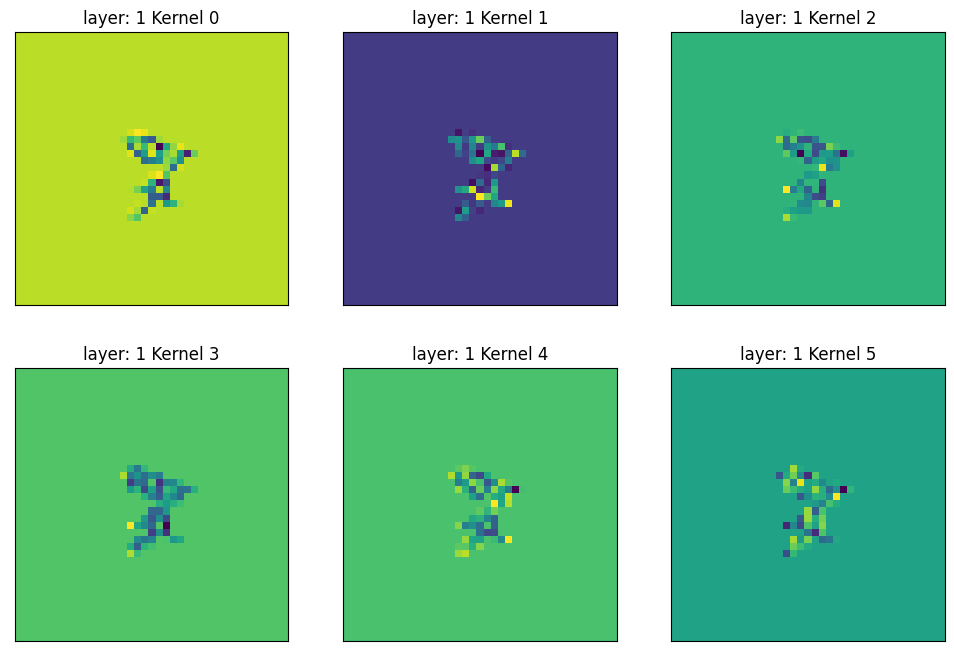

1/1 [==============================] - 0s 81ms/step


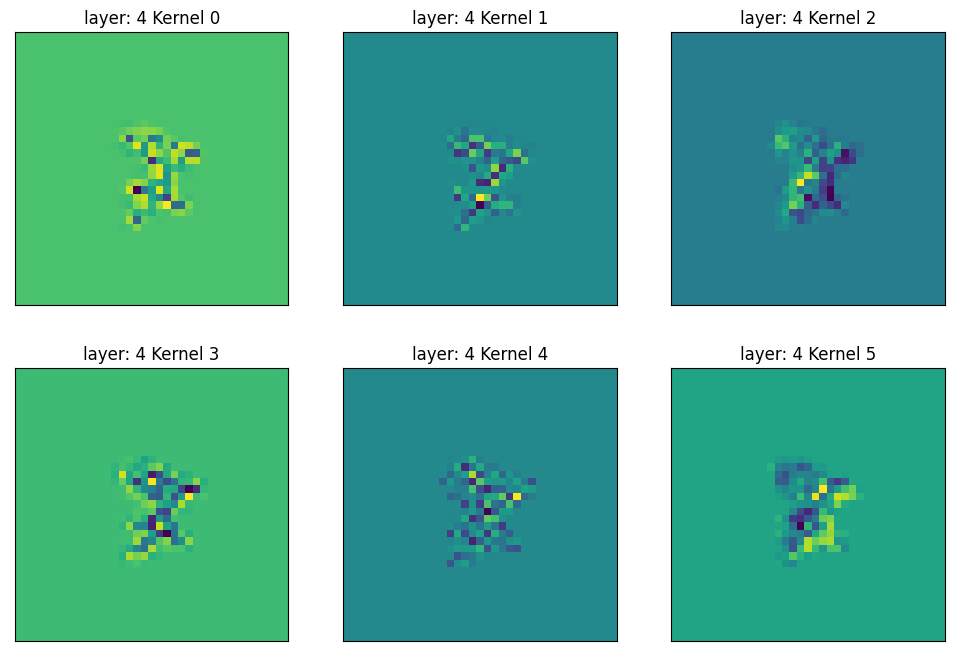

1/1 [==============================] - 0s 53ms/step


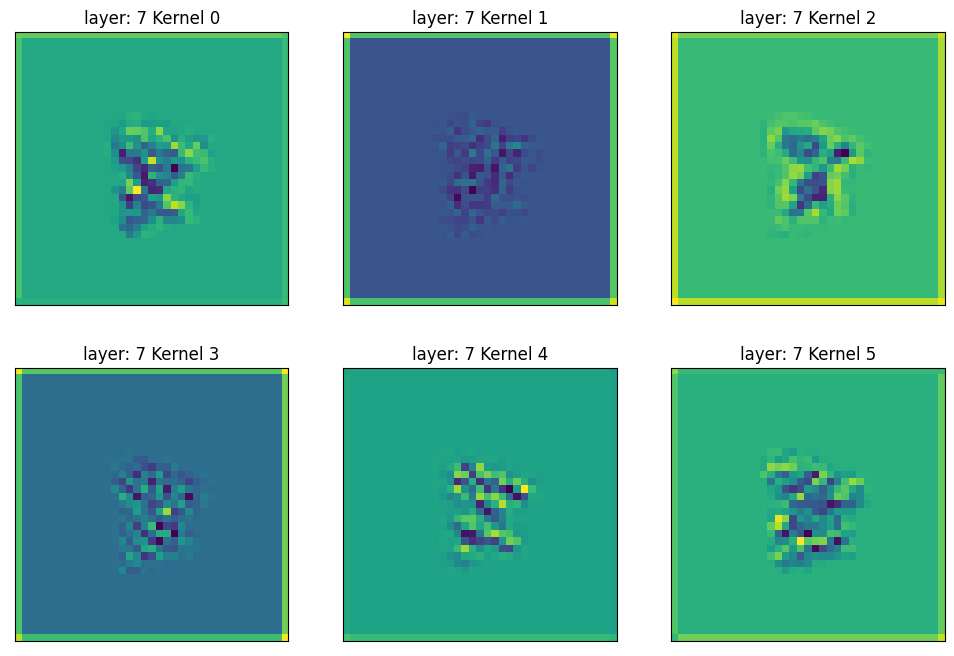

In [130]:
conv_layers = [(i, layer) for i, layer in enumerate(model.layers) if 'conv' in layer.name]
plt.imshow(X_train[14271,:,:,:])
for layer in conv_layers:
    if layer[1].output_shape[1] > 28:
        layer1_model = Model(inputs=model.input,
                    outputs=model.layers[layer[0]].output)
 
        kernels1 = layer1_model.predict(X_train[14271:14272,:,:,:])[0]
        plot_kernels(kernels1, layer[0])
        plt.show()
        

In [72]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_kernels(kernels, ncols=8):
#     num_kernels = kernels.shape[-1]
#     nrows = int(np.ceil(num_kernels / ncols))

#     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
#     axes = axes.flatten()
    
#     for i in range(num_kernels):
#         ax = axes[i]
#         ax.matshow(kernels[:, :, i], cmap='viridis')
#         ax.set_title(f"Kernel {i}")

#     # Remove empty plots if any
#     for i in range(num_kernels, len(axes)):
#         fig.delaxes(axes[i])

#     plt.tight_layout()
#     plt.show()
    
    
# layerX_model = Model(inputs=model.input, outputs=model.layers[-5].output)
# kernelsX = layerX_model.predict(X_train[14271:14272,:,:,:])[0]
# plot_kernels(kernelsX)


In [104]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def plot_kernels(kernels, ncols=3):
#     num_kernels = 6
#     nrows = 2

#     fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=[f"Kernel {i}" for i in range(num_kernels)])

#     for i in range(num_kernels):
#         row, col = divmod(i, ncols)
#         row += 1
#         col += 1

#         # Create an annotated heatmap with the kernel values
#         heatmap = go.Heatmap(z=kernels[:, :, i], colorscale='Viridis', zmin=-1, zmax=1)

#         fig.add_trace(heatmap, row=row, col=col)

#     fig.update_layout(height=500, width=700, title_text="Kernels")
#     fig.show()

# # Visualize the kernels
# layer1_model = Model(inputs=model.input, outputs=model.layers[5].output)
# kernels1 = layer1_model.predict(X_train[14271:14272, :, :, :])[0]
# plot_kernels(kernels1)


# Comparing other models

### Random Forest
Random forest is one of the most prominent models in the field of machine learning, especially in tabular data. The feauturization method that will be used will be `Circular Fingerprints (CFP).`

In [109]:
from sklearn.ensemble import RandomForestClassifier
from deepchem.feat import CircularFingerprint

featurizer = CircularFingerprint(size=1024)
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_val, y_val = featurizer.featurize(val_df["smiles"]), val_df["label"]
X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)


0.6928773188793038

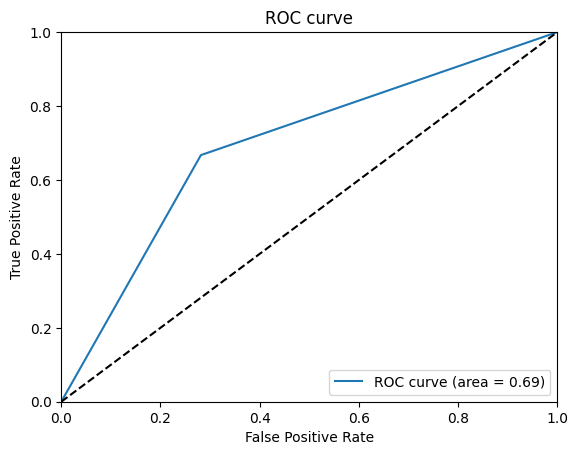

In [111]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict(X_test))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### Graph Convolutional Network

In [117]:
from deepchem.models import GraphConvModel
from deepchem.feat import ConvMolFeaturizer
import deepchem as dc

featurizer = ConvMolFeaturizer()
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

train_dataset = dc.data.NumpyDataset(X_train, y_train)
test_dataset = dc.data.NumpyDataset(X_val, y_val)

model = GraphConvModel(n_tasks=1, mode='classification', dropout=0.2)
model.fit(train_dataset, nb_epoch=50)

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/private__graph_conv_keras_model/graph_gather/and' defined at (most recent call last):
    File "/opt/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/miniconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/miniconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/miniconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/7n/ynz1z7qd3fbg7568r_zgsb980000gn/T/ipykernel_51712/3136255222.py", line 13, in <module>
      model.fit(train_dataset, nb_epoch=50)
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 351, in fit
      return self.fit_generator(
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 441, in fit_generator
      batch_loss = apply_gradient_for_batch(inputs, labels, weights, loss)
    File "/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/keras_model.py", line 507, in apply_gradient_for_batch
      grads = tape.gradient(batch_loss, vars)
Node: 'gradient_tape/private__graph_conv_keras_model/graph_gather/and'
No registered 'BroadcastTo' OpKernel for 'GPU' devices compatible with node {{node gradient_tape/private__graph_conv_keras_model/graph_gather/and}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_BOOL, Tidx=DT_INT32, _XlaHasReferenceVars=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"
	.  Registered:  device='XLA_CPU_JIT'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 930109355527764061, DT_HALF, DT_UINT32, DT_UINT64, DT_FLOAT8_E5M2, DT_FLOAT8_E4M3FN]
  device='GPU'; T in [DT_FLOAT]
  device='DEFAULT'; T in [DT_INT32]
  device='CPU'; T in [DT_UINT64]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_UINT32]
  device='CPU'; T in [DT_UINT16]
  device='CPU'; T in [DT_INT16]
  device='CPU'; T in [DT_UINT8]
  device='CPU'; T in [DT_INT8]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_BOOL]
  device='CPU'; T in [DT_STRING]
  device='CPU'; T in [DT_RESOURCE]
  device='CPU'; T in [DT_VARIANT]

	 [[gradient_tape/private__graph_conv_keras_model/graph_gather/and]] [Op:__inference_apply_gradient_for_batch_97896]

# References

https://www.researchgate.net/publication/317732180_Chemception_A_Deep_Neural_Network_with_Minimal_Chemistry_Knowledge_Matches_the_Performance_of_Expert-developed_QSARQSPR_Models